## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# GPU 사용시 메모리 부족으로 에러 발생시 아래 줄 주석 풀고 실행
# device = 'cpu'
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080


## load data

In [3]:
xy = pd.read_csv('../data/df_short.csv')
xy

,일시,평균기온(°C),합계 일사량(MJ/m2),평균 지면온도(°C),평균 30cm 지중온도(°C),5.0m 지중온도(°C),일 미세먼지 농도(㎍/㎥),승차,검색량,당일 1차접종자 수,...,2차접종 누계,2차접종률(%),당일 3차접종자 수,3차접종 누계,3차접종률(%),mx,my,dx,dy,추가 확진
0,20200205,-8.3,14.82,-2.5,3.0,15.6,28.0,6855972,3.76198,0.0,...,0,0.0,0,0,0,0.866025,0.500000,8.835120e-01,0.468408,3
1,20200206,-6.4,13.97,-2.7,2.3,15.5,46.0,6774345,4.73247,0.0,...,0,0.0,0,0,0,0.866025,0.500000,9.635500e-01,0.267528,0
2,20200207,-1.7,10.14,-0.4,1.9,15.5,44.0,7188696,4.26499,0.0,...,0,0.0,0,0,0,0.866025,0.500000,9.985334e-01,0.054139,0
3,20200208,-0.1,13.89,1.4,1.9,15.4,50.0,4677705,3.40660,0.0,...,0,0.0,0,0,0,0.866025,0.500000,9.868265e-01,-0.161782,0
4,20200209,-0.5,14.33,0.5,2.2,15.4,42.0,3442364,3.06098,0.0,...,0,0.0,0,0,0,0.866025,0.500000,9.289767e-01,-0.370138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,20210730,30.5,21.86,33.5,29.2,15.1,30.0,5622363,7.58533,80425.0,...,1325451,31.8,0,0,0,-0.500000,-0.866025,-2.012985e-01,0.979530,476
545,20210731,29.8,21.19,31.6,29.5,15.2,25.0,3417145,5.59367,39795.0,...,1329899,31.9,0,0,0,-0.500000,-0.866025,-2.450000e-16,1.000000,473
546,20210801,27.1,6.56,28.3,29.1,15.2,40.0,2395940,5.41883,5674.0,...,1329967,34.9,0,0,0,-0.866025,-0.500000,2.012985e-01,0.979530,365
547,20210802,26.5,8.42,27.8,28.2,15.2,20.0,5284339,6.87290,77877.0,...,1337105,31.0,0,0,0,-0.866025,-0.500000,3.943559e-01,0.918958,311


## data information

In [4]:
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   일시                549 non-null    int64  
 1   평균기온(°C)          549 non-null    float64
 2   합계 일사량(MJ/m2)     549 non-null    float64
 3   평균 지면온도(°C)       549 non-null    float64
 4   평균 30cm 지중온도(°C)  549 non-null    float64
 5   5.0m 지중온도(°C)     549 non-null    float64
 6   일 미세먼지 농도(㎍/㎥)    549 non-null    float64
 7   승차                549 non-null    int64  
 8   검색량               549 non-null    float64
 9   당일 1차접종자 수        549 non-null    float64
 10  1차접종 누계           549 non-null    float64
 11  1차접종률(%)          549 non-null    float64
 12  당일 2차접종자 수        549 non-null    int64  
 13  2차접종 누계           549 non-null    int64  
 14  2차접종률(%)          549 non-null    float64
 15  당일 3차접종자 수        549 non-null    int64  
 16  3차접종 누계           549 non-null    int64  
 1

## hyper parameter

In [5]:
seq_length = 5              # 5 일치의 데이터 입력
data_dim = len(xy.iloc[0])-1# feature 개수
hidden_dim = 15     
output_dim = 1
learning_rate = 0.001
epoch = 300
train_size = int(len(xy) * 0.8)

## Scaling

In [6]:
scaler = MinMaxScaler()
origin_scale = xy.iloc[:, [-1]].to_numpy()

# 입력변수를 MinMaxScaling 하기
xy.iloc[:,1:] = scaler.fit_transform(xy.iloc[:,1:])

/tmp/ipykernel_363446/2312763585.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  xy.iloc[:,1:] = scaler.fit_transform(xy.iloc[:,1:])


## result of scaling & train/test_set

In [7]:
# train set과 test set 나누기
train_size = int(len(xy) * 0.8)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]
test_set

,일시,평균기온(°C),합계 일사량(MJ/m2),평균 지면온도(°C),평균 30cm 지중온도(°C),5.0m 지중온도(°C),일 미세먼지 농도(㎍/㎥),승차,검색량,당일 1차접종자 수,...,2차접종 누계,2차접종률(%),당일 3차접종자 수,3차접종 누계,3차접종률(%),mx,my,dx,dy,추가 확진
434,20210414,0.500000,0.893826,0.495614,0.444444,0.038462,0.117187,0.826857,0.061664,0.032704,...,0.001694,0.004943,0.0,0.0,0.0,0.933013,0.250000,0.603956,0.010926,0.340125
435,20210415,0.568670,0.808005,0.530702,0.447712,0.019231,0.171875,0.820072,0.052440,0.032704,...,0.003388,0.009885,0.0,0.0,0.0,0.933013,0.250000,0.500000,0.000000,0.338558
436,20210416,0.562232,0.258820,0.480263,0.457516,0.019231,0.255208,0.819474,0.042002,0.032704,...,0.005082,0.014828,0.0,0.0,0.0,0.933013,0.250000,0.396044,0.010926,0.340125
437,20210417,0.525751,0.429444,0.471491,0.428105,0.019231,0.260417,0.465846,0.025891,0.032704,...,0.005082,0.019771,0.0,0.0,0.0,0.933013,0.250000,0.296632,0.043227,0.321317
438,20210418,0.532189,0.881275,0.510965,0.418301,0.019231,0.117187,0.276666,0.025854,0.032704,...,0.006775,0.024140,0.0,0.0,0.0,0.933013,0.250000,0.206107,0.095492,0.214734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,20210730,0.974249,0.708955,0.938596,0.977124,0.326923,0.065104,0.658765,0.058361,0.486643,...,0.976129,0.911175,0.0,0.0,0.0,0.250000,0.066987,0.399351,0.989765,0.746082
545,20210731,0.959227,0.686228,0.896930,0.986928,0.346154,0.052083,0.299728,0.038068,0.240795,...,0.979404,0.914040,0.0,0.0,0.0,0.250000,0.066987,0.500000,1.000000,0.741379
546,20210801,0.901288,0.189959,0.824561,0.973856,0.346154,0.091146,0.133462,0.036286,0.034333,...,0.979455,1.000000,0.0,0.0,0.0,0.066987,0.250000,0.600649,0.989765,0.572100
547,20210802,0.888412,0.253053,0.813596,0.944444,0.346154,0.039062,0.603731,0.051102,0.471225,...,0.984711,0.888252,0.0,0.0,0.0,0.066987,0.250000,0.697178,0.959479,0.487461


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 434 to 548
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   일시                115 non-null    int64  
 1   평균기온(°C)          115 non-null    float64
 2   합계 일사량(MJ/m2)     115 non-null    float64
 3   평균 지면온도(°C)       115 non-null    float64
 4   평균 30cm 지중온도(°C)  115 non-null    float64
 5   5.0m 지중온도(°C)     115 non-null    float64
 6   일 미세먼지 농도(㎍/㎥)    115 non-null    float64
 7   승차                115 non-null    float64
 8   검색량               115 non-null    float64
 9   당일 1차접종자 수        115 non-null    float64
 10  1차접종 누계           115 non-null    float64
 11  1차접종률(%)          115 non-null    float64
 12  당일 2차접종자 수        115 non-null    float64
 13  2차접종 누계           115 non-null    float64
 14  2차접종률(%)          115 non-null    float64
 15  당일 3차접종자 수        115 non-null    float64
 16  3차접종 누계           115 non-null    float64


## dataset function

In [9]:
def sliding_windows(time_series, seq_length, day):
    dataX = []
    dataY = []
    for i in range(len(time_series) - seq_length - day+1):
        _x = time_series.iloc[i:i+seq_length, 1:]
        _y = time_series.iloc[i+seq_length+day-1, [-1]]
        print(_x, '->', _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

## build dataset

In [10]:
trainX, trainY = sliding_windows(train_set, seq_length, 14)
testX, testY = sliding_windows(test_set, seq_length, 14)

   평균기온(°C)  합계 일사량(MJ/m2)  평균 지면온도(°C)  평균 30cm 지중온도(°C)  5.0m 지중온도(°C)  \
0  0.141631       0.470149     0.149123          0.120915       0.423077   
1  0.182403       0.441316     0.144737          0.098039       0.403846   
2  0.283262       0.311398     0.195175          0.084967       0.403846   
3  0.317597       0.438602     0.234649          0.084967       0.384615   
4  0.309013       0.453528     0.214912          0.094771       0.384615   

   일 미세먼지 농도(㎍/㎥)        승차       검색량  당일 1차접종자 수  1차접종 누계  ...  2차접종 누계  \
0        0.059896  0.859613  0.019404         0.0      0.0  ...      0.0   
1        0.106771  0.846323  0.029293         0.0      0.0  ...      0.0   
2        0.101562  0.913785  0.024529         0.0      0.0  ...      0.0   
3        0.117187  0.504963  0.015783         0.0      0.0  ...      0.0   
4        0.096354  0.303834  0.012261         0.0      0.0  ...      0.0   

   2차접종률(%)  당일 3차접종자 수  3차접종 누계  3차접종률(%)        mx    my        dx  \
0       0.0   

### array -> tensor

In [11]:
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)
testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)


# RNN

In [12]:
class Net(nn.Module):
    def __init__(self, data_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.rnn = nn.RNN(data_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

net = Net(data_dim, hidden_dim, output_dim).to(device)

# loss & optimizer setting
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate) # 0.001

### Learning

In [13]:
from tqdm import tqdm
for i in tqdm(range(epoch)):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()

100%|██████████| 300/300 [00:00<00:00, 787.46it/s]


In [14]:
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(origin_scale)
inverse_x = inverse_scaler.inverse_transform(net(testX_tensor).cpu().detach().numpy())
inverse_y = inverse_scaler.inverse_transform(testY)

In [15]:
date = []
for i in range(0, len(inverse_y), 19):
    md = test_set.iloc[i+5, 0] - 20210000
    m = md // 100
    d = md % 100
    print(m, d)
    date.append(str(m)+'/'+str(d))

date

4 19
5 8
5 24
6 12
7 1
7 20


['4/19', '5/8', '5/24', '6/12', '7/1', '7/20']

# day 14

/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49483 (\N{HANGUL SYLLABLE SES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dku/.l

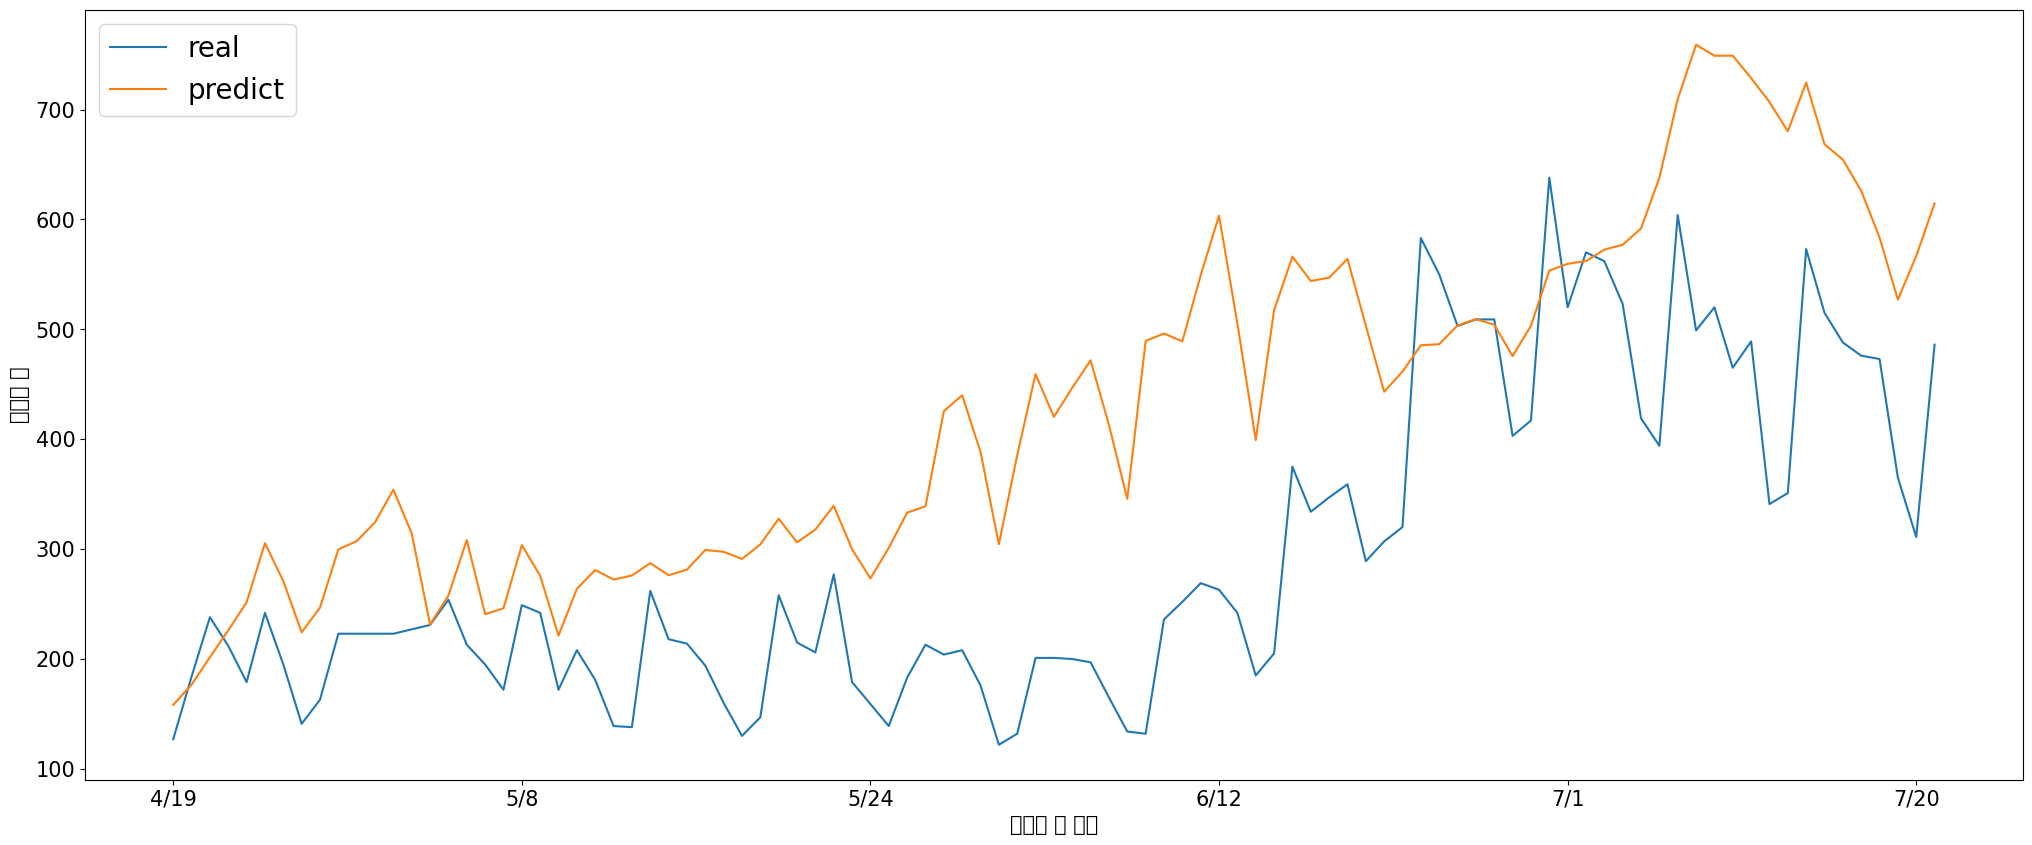

In [16]:
plt.rc('font', size=15) # font가 지정되어 있다면 한글 출력 가능
plt.figure(figsize=(25,10))
plt.plot(inverse_y, label = 'real')
plt.plot(inverse_x, label = 'predict')
plt.xticks(range(0, len(inverse_y), 19), labels = date)
plt.xlabel('테스트 셋 일자')
plt.ylabel('확진자 수')
plt.rc('legend', fontsize = 20)
plt.legend()
plt.show()

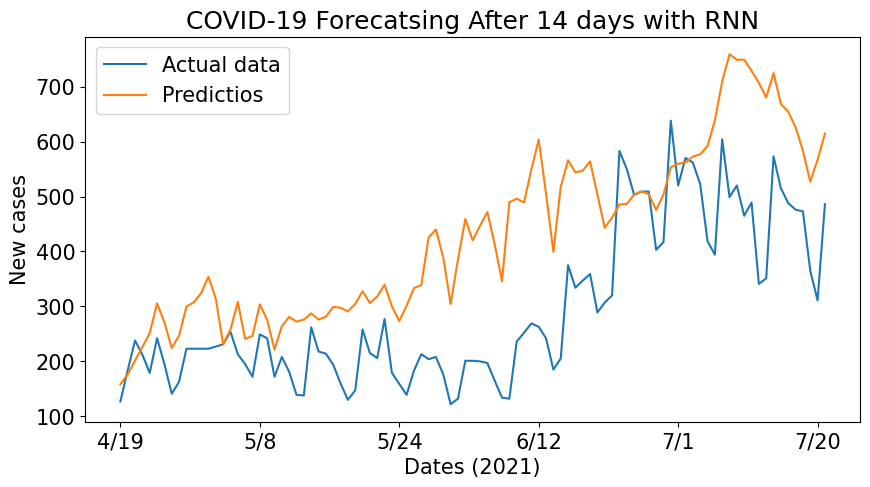

In [17]:
plt.rc('font', size=15)
plt.figure(figsize=(10,5))
plt.plot(inverse_y, label = 'Actual data')
plt.plot(inverse_x, label = 'Predictios')
plt.xticks(range(0, len(inverse_y), 19), labels = date)
plt.title('COVID-19 Forecatsing After 14 days with RNN')
plt.xlabel('Dates (2021)')
plt.ylabel('New cases')
plt.rc('legend', fontsize = 15)
plt.legend()
plt.show()

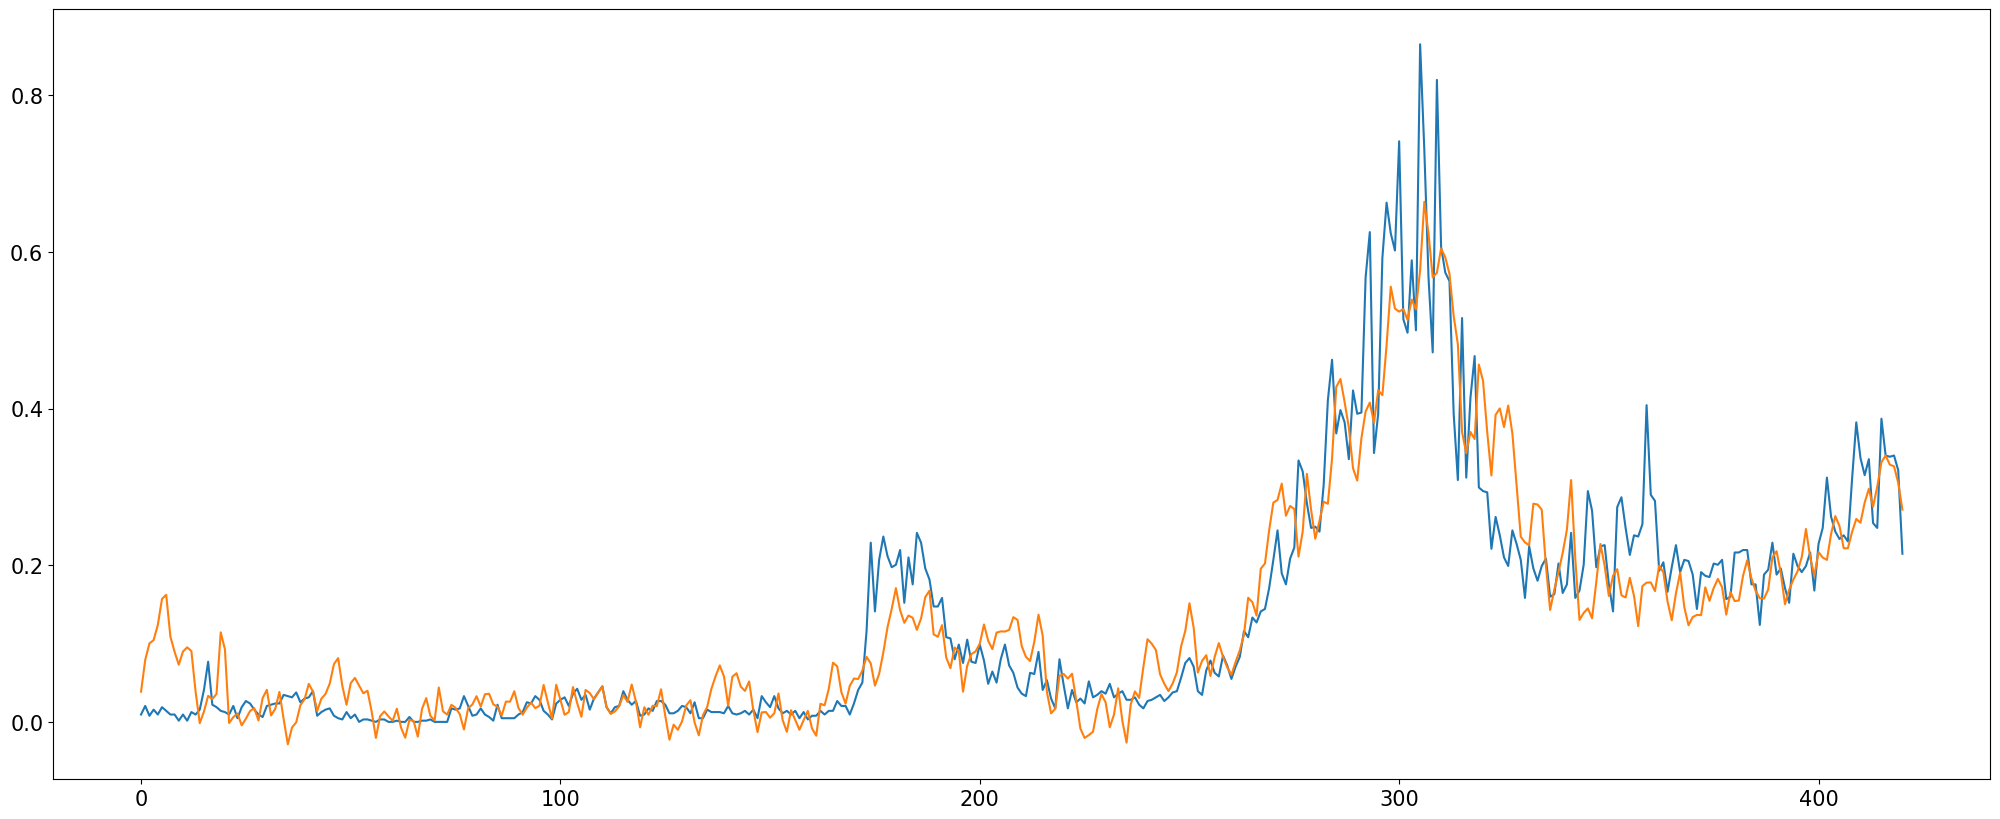

In [18]:
plt.figure(figsize=(25,10))
plt.plot(trainY)
plt.plot(net(trainX_tensor).cpu().data.numpy())
plt.show()

### RMSE 구하기

In [19]:
def rmse(pred, real):
    E = pred-real
    SE = []
    for i in E:
        SE.append(i**2)
    MSE = sum(SE)/len(SE)
    RMSE = MSE**0.5
    return RMSE


print(f'RMSE : {rmse(inverse_x.flatten(), inverse_y.flatten())}')

RMSE : 167.71555324362788
